#  Modelo de ZeeHB

Sample of notebook for specific model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
import hep as hp
from matplotlib.colors import LogNorm

In [3]:
def func(s2phi, M1, M2, MAo, Mho, MHo, v, lam2, lam3, lam6, lam7, lam8, lam9, lam10, lamh):
    M12 = M1*M1; M22 = M2*M2; MAo2 = MAo*MAo; Mho2 = Mho*Mho; MHo2 = MHo*MHo;
    k = s2phi*np.log(M22/M12)/(4.*np.pi)**2
    phi = 0.5*np.arcsin(s2phi)
    Mu  = (M22-M12)*s2phi/(np.sqrt(2.0)*v)
    MH2 = M12*(np.sin(phi))**2+M22*(np.cos(phi))**2
    M332 = M12*(np.cos(phi))**2+M22*(np.sin(phi))**2
    lam1 = 0.5*(MHo2+Mho2-np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2))/(v**2)
    Mu22 = MH2-0.5*lam3*(v**2)
    Muh2 = M332-0.5*lam8*(v**2)
    lam4 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2+2.0*(MAo2-2.0*MH2))/(v**2)
    lam5 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2-2.0*MAo2)/(v**2)    
    return k, Mu, Muh2, Mu22, lam1, lam4, lam5

In [4]:
import hep as hp
def Kappa(s2phi,M1,M2):
    return s2phi*np.log(M2**2/M1**2)/(4.*np.pi)**2

def Inverse_Zee_Matrix(kappa,t12,t13,t23,ml,IH=False,sgnm2=-1,sgnml=1):
    """Inverse neutrino mass matrix normalized by kappa from
        Mnu_diag=U^T.(kappa Y).U
        ,
        (Inverse_Zee_Matrix) = U. Mnu_diag.U^T/kappa
        sgnm2=-1 guarantees real Yukawa couplings
        
    requires hep.py:
       https://github.com/restrepo/BSM-Toolbox/blob/master/tests/hep.py
    """
    if not IH:
        mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(CL=3,IH=False,mnu1in=1E-5*1E-9)
        theta12[1] = t12
        theta13[1] = t13
        theta23[1] = t23
        U=hp.UPMNS(theta12[1],theta13[1],theta23[1])
        m1=ml; m2=sgnm2*np.sqrt(Dm21_2[1]+m1**2); m3=sgnml*np.sqrt(Dm3l_2[1]+m1**2)
    else:
        mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(CL=3,IH=True,mnu1in=1E-5*1E-9)
        #DEBUG signs
        m3=ml; m2=sgnm2*np.sqrt(-Dm3l_2[1]+m3**2); m1=sgnml*np.sqrt(m2**2-Dm21_2[1])
        theta12[1] = t12
        theta13[1] = t13
        theta23[1] = t23
        U=hp.UPMNS(theta12[1],theta13[1],theta23[1])
        
    return np.dot( np.dot( U,np.diag([m1,m2,m3]) ), U.transpose() )/kappa

def get_yukawas(X,q01=1e-3,q02=1e-6,q10=200e-3,q12=0.0,q21=-1e-5,q22=0,m_e=0.5109989461e-3,m_mu=0.1056583745,m_tau=1.77686):
    """
    Get the O and f full Yukawa mass matrices which define the neutrino mass matrix in the Zee model
      Mnu=kappa*(O.M_lep.f^T+f.M_lep.O^T)
    where M_lep is the diagonal matrix with the charged leptons
    
    The input X is the output of the `def Inverse_Zee_Matrix(...)` in this module
    """
    import numpy.lib.scimath as sc # .sqrt -> returns complex for sqrt(negative real)
    ml=np.array([m_e,m_mu,m_tau])
    Q=np.zeros((3,3))
    f=np.zeros((3,3))
    Q[0,1]=q01;Q[0,2]=q02;Q[1,0]=q10;Q[1,2]=q12;Q[2,1]=q21;Q[2,2]=q22
    Q[2,0]=( -(ml[0]**3*Q[1,0]**2*X[0,0]**2*(ml[1]*Q[2,1]*X[0,1] + ml[2]*Q[0,2]*X[2,2])) -\
      ml[0]*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])*(ml[1]*Q[0,1]*((ml[1]*Q[0,1]*X[0,1] +\
      ml[2]*Q[0,2]*X[0,2])*X[1,1] + ml[2]*Q[1,2]*X[0,0]*X[1,2]) +\
      ml[2]**2*Q[0,2]*Q[1,2]*X[0,0]*X[2,2]) + ml[0]**2*Q[1,0]*X[0,0]*(-(ml[1]*Q[2,1]*((2*ml[1]*Q[0,1]*X[0,1] +\
      ml[2]*Q[0,2]*X[0,2])*X[1,1] + ml[2]*Q[1,2]*X[0,0]*X[1,2])) -\
      ml[2]*(2*ml[2]*Q[0,2]*Q[1,2]*X[0,2] + ml[1]*Q[0,1]*(Q[1,2]*X[0,1] + Q[0,2]*X[1,1]))*X[2,2]) +\
      sc.sqrt( -(ml[0]**2*ml[1]**2*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] + Q[0,1]*(ml[1]*Q[2,1]*X[1,1] +\
      ml[2]*Q[1,2]*X[2,2]))**2*(ml[0]**2*Q[1,0]**2*X[0,0]**2*(-X[0,1]**2 + X[0,0]*X[1,1]) +\
      ml[1]**2*Q[0,1]**2*X[1,1]**2*(-X[0,1]**2 + X[0,0]*X[1,1]) +\
      2*ml[1]*ml[2]*Q[0,1]*X[1,1]*((Q[1,2]*X[0,0] - Q[0,2]*X[0,1])*X[0,2]*X[1,1] + X[0,0]*(-(Q[1,2]*X[0,1]) +\
      Q[0,2]*X[1,1])*X[1,2]) + 2*ml[0]*Q[1,0]*X[0,0]*(X[1,1]*(ml[2]*(Q[1,2]*X[0,0] - Q[0,2]*X[0,1])*X[0,2] +\
      ml[1]*Q[0,1]*(-X[0,1]**2 + X[0,0]*X[1,1])) + ml[2]*X[0,0]*(-(Q[1,2]*X[0,1]) + Q[0,2]*X[1,1])*X[1,2]) +\
      ml[2]**2*(-(Q[0,2]*X[0,2]*X[1,1] - Q[1,2]*X[0,0]*X[1,2])**2 + X[0,0]*X[1,1]*(Q[1,2]**2*X[0,0] -\
      2*Q[0,2]*Q[1,2]*X[0,1] + Q[0,2]**2*X[1,1])*X[2,2])))    )   )/\
      (ml[0]**2*X[0,0]*((ml[0]*Q[1,0]*X[0,0] + ml[1]*Q[0,1]*X[1,1])*(ml[0]*Q[1,0]*X[0,0] +\
       2*ml[2]*Q[1,2]*X[0,2] + ml[1]*Q[0,1]*X[1,1]) + ml[2]**2*Q[1,2]**2*X[0,0]*X[2,2]))

    Q[0,0]=(ml[0]**2*Q[0,1]*Q[1,0]*Q[2,0]*X[0,0] - ml[2]*(Q[0,2]*Q[2,1] -\
        Q[0,1]*Q[2,2])*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2]) +\
        ml[0]*(ml[1]*Q[0,1]**2*Q[2,0]*X[1,1] + ml[2]*(Q[1,2]*Q[2,0]*(-(Q[2,1]*X[0,0]) +\
        2*Q[0,1]*X[0,2]) + Q[1,0]*(Q[2,1]*(Q[2,2]*X[0,0] - 2*Q[0,2]*X[0,2]) +\
        Q[0,1]*Q[0,2]*X[2,2]))))/(ml[0]*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] +\
        Q[0,1]*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])))
    
    Q[1,1]=(ml[0]**3*Q[1,0]*Q[2,0]*(Q[0,1]*Q[1,2]*Q[2,0] - Q[0,2]*Q[1,0]*Q[2,1])*X[0,0]**2 +\
        ml[0]*(2*ml[1]*Q[0,1]*(Q[0,1]*Q[1,2]*Q[2,0]*X[0,1] + Q[1,0]*Q[2,1]*(Q[1,2]*X[0,0] -\
        Q[0,2]*X[0,1])) + ml[2]*(Q[0,1]*Q[1,2]*Q[2,0]*Q[2,2]*X[0,0] -\
        2*Q[0,2]**2*Q[1,0]*Q[2,1]*X[0,2] + Q[0,2]*(Q[1,0]*Q[2,1]*Q[2,2]*X[0,0] +\
        2*Q[1,2]*Q[2,0]*(-(Q[2,1]*X[0,0]) + Q[0,1]*X[0,2]))))*(ml[1]*Q[2,1]*X[1,1] +\
        ml[2]*Q[1,2]*X[2,2]) + (ml[1]*Q[0,1]**2*Q[1,2] + ml[2]*Q[0,2]*(-(Q[0,2]*Q[2,1]) +\
        Q[0,1]*Q[2,2]))*(ml[1]*Q[2,1]*X[1,1] + ml[2]*Q[1,2]*X[2,2])**2 +\
        ml[0]**2*X[0,0]*(ml[1]*(Q[1,0]**2*Q[2,1]**2*(Q[1,2]*X[0,0] - 2*Q[0,2]*X[0,1]) +\
        Q[0,1]**2*Q[1,2]*Q[2,0]**2*X[1,1] + Q[0,1]*Q[1,0]*Q[2,0]*Q[2,1]*(2*Q[1,2]*X[0,1] -\
        Q[0,2]*X[1,1])) + ml[2]*(Q[1,2]**2*Q[2,0]**2*(-(Q[2,1]*X[0,0]) + 2*Q[0,1]*X[0,2]) -\
        Q[0,2]**2*Q[1,0]**2*Q[2,1]*X[2,2] + Q[1,0]*Q[1,2]*Q[2,0]*(Q[2,1]*(Q[2,2]*X[0,0] -\
        2*Q[0,2]*X[0,2]) + Q[0,1]*Q[0,2]*X[2,2]))))/\
        (ml[1]*(ml[0]*Q[1,0]*Q[2,1]*X[0,0] + Q[0,1]*(ml[1]*Q[2,1]*X[1,1] +\
         ml[2]*Q[1,2]*X[2,2]))*(ml[0]*Q[1,2]*Q[2,0]*X[0,0] + Q[0,2]*(ml[1]*Q[2,1]*X[1,1] +\
         ml[2]*Q[1,2]*X[2,2])))    
        
    f[0,1]=(ml[0]*Q[1,2]*Q[2,0]*X[0,0] + ml[1]*Q[0,2]*Q[2,1]*X[1,1] + ml[2]*Q[0,2]*Q[1,2]*X[2,2])/\
       (2*ml[0]*ml[1]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[0]*ml[1]*Q[0,2]*Q[1,0]*Q[2,1])
    f[0,2]=-((ml[0]*Q[1,0]*Q[2,1]*X[0,0] + ml[1]*Q[0,1]*Q[2,1]*X[1,1] + ml[2]*Q[0,1]*Q[1,2]*X[2,2])/\
        (2*ml[0]*ml[2]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[0]*ml[2]*Q[0,2]*Q[1,0]*Q[2,1]))
    f[1,2]=(ml[0]*Q[1,0]*Q[2,0]*X[0,0] + ml[1]*Q[0,1]*Q[2,0]*X[1,1] + ml[2]*Q[0,2]*Q[1,0]*X[2,2])/\
       (2*ml[1]*ml[2]*Q[0,1]*Q[1,2]*Q[2,0] - 2*ml[1]*ml[2]*Q[0,2]*Q[1,0]*Q[2,1])
    f[1,0]=-f[0,1]; f[2,0]=-f[0,2]; f[2,1]=-f[1,2]
    
    return Q,f

def test_Zee():
    m_e=0.5109989461e-3;m_mu=0.1056583745;m_tau=1.77686
    mlep=np.diag([m_e,m_mu,m_tau])
    m1=0 # lightest neutrino
    s2phi=0.014; M1=200.; M2=300.
    t12=33.56*180.0/np.pi
    t13=8.49*180.0/np.pi
    t23=41.6*180.0/np.pi
    X=Inverse_Zee_Matrix(Kappa(s2phi,M1,M2),t12,t13,t23,m1)
    O,f=get_yukawas(X) #Use default input values
    Mnu=Kappa(s2phi,M1,M2)*( np.dot( np.dot(O,mlep),f.transpose() )+np.dot( np.dot(f,mlep),O.transpose()) )
    Mnu_diag,U=np.linalg.eig(Mnu)
    lo=np.argsort(np.abs(Mnu_diag))
    Mnu_diag=np.array([Mnu_diag[lo[0]],Mnu_diag[lo[1]],Mnu_diag[lo[2]]])
    U=np.matrix(U)
    U=np.asarray(np.hstack((U[:,lo[0]],U[:,lo[1]],U[:,lo[2]])))
    
    mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(CL=3,IH=False,mnu1in=1E-5*1E-9)
    m2=np.sqrt(Dm21_2[1]+m1**2); m3=np.sqrt(Dm3l_2[1]+m1**2)
    theta12[1] = t12
    theta13[1] = t13
    theta23[1] = t23
    
    np.testing.assert_array_almost_equal(np.abs(U),\
        np.abs( hp.UPMNS(theta12[1],theta13[1],theta23[1]) ) )
    
    return np.testing.assert_almost_equal( np.abs(Mnu_diag),np.abs([m1,m2,m3]) ) 

In [5]:
test_Zee()

In [6]:
muegamma = 5.7E-13
tauegamma = 3.3E-08
taumugamma = 4.4E-08
mu3e = 1.0E-12
tau3mu = 2.1E-08
tauemumu = 2.7E-08
taumuee = 1.8E-08
tau3e = 2.7E-08
mueTi = 4.3E-12
mueAu = 7.0E-13

LFV = np.array([muegamma, tauegamma, taumugamma, mu3e, tau3mu, tauemumu, taumuee, tau3e, mueTi, mueAu])


## Check one point

In [7]:
a=hp.hep(MODEL='radinuZeeHB')

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

In [8]:
pd.Series(a.LHA.blocks['MINPAR'].entries)

1      1.0000000E-01   # lambda1Input
2      1.3000000E-01   # lambda2Input
3      1.1000000E+00   # lambda3Input
4      -5.0000000E-01  # lambda4Input
5      5.0000000E-01   # lambda5Input
6      0.000000E+00    # lambda6Input
7      0.000000E+00    # lambda7Input
8      0.000000E+00    # lambda8Input
9      0.000000E+00    # lambda9Input
10    0.000000E+00    # lambda10Input
11     0.000000E+00    # lambdahInput
12          0.000000E+00    # MhInput
13          0.000000E+00    # MuInput
14        4.0000000E+04   # mEt2Input
dtype: object

for i in something....

In [9]:
df = pd.DataFrame()

Me   = 0.5109989461e-3     #Masa Electron en GeV
Mmu  = 0.1056583745        #Masa Muon en GeV
Mtau = 1.77686             #Masa Tauon en GeV

v = a.vev
s2phi = 0.014
M1 = 800.0
M2 = 1000.0
MAo = 810.0
Mho = 125.0
MHo = 805.0
lam2 = 1.3000000E-01    # lambda2Input
lam3 = 1.0000000E-03    # lambda3Input
lam6 = 1.000000E-03     # lambda6Inputd 
lam7 = 0.000000E+00     # lambda7Input
lam8 = 0.0000000E-01    # lambda8Input
lam9 = 0.000000E+00     # lambda9Input
lam10 = 0.000000E+00    # lambda10Input
lamh = 0.000000E+00     # lambdahInput


k, Mu, Muh2, Mu22, lam1, lam4, lam5 = func(s2phi, M1, M2, MAo, Mho, MHo, v, lam2, lam3, lam6, lam7, lam8, lam9, lam10, lamh)

devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)

a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][1]='%0.8E       #lambda1Input' %lam1
a.LHA.blocks['MINPAR'][2]='%0.8E       #lambda2Input' %lam2
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lam3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lam4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lam5
a.LHA.blocks['MINPAR'][6]='%0.8E       #lambda6Input' %lam6
a.LHA.blocks['MINPAR'][7]='%0.8E       #lambda7Input' %lam7
a.LHA.blocks['MINPAR'][8]='%0.8E       #lambda8Input' %lam8
a.LHA.blocks['MINPAR'][9]='%0.8E       #lambda9Input' %lam9
a.LHA.blocks['MINPAR'][10]='%0.8E      #lambda10Input'%lam10
a.LHA.blocks['MINPAR'][11]='%0.8E      #lambdahInput' %lamh
a.LHA.blocks['MINPAR'][12]='%0.8E      #MhInput'      %Muh2
a.LHA.blocks['MINPAR'][13]='%0.8E      #MuInput'      %Mu
a.LHA.blocks['MINPAR'][14]='%0.8E      #mEt2Input'    %Mu22

m3= 0.0  # lightest neutrino
t12=33.56*180.0/np.pi
t13=8.49*180.0/np.pi
t23=41.6*180.0/np.pi
X=Inverse_Zee_Matrix(k,t12,t13,t23,m3,IH=True,sgnm2=-1,sgnml=1)
O,f=get_yukawas(X) #Use default input values
    
Yh12 = f[0,1]     # Yh(1,2)
Yh13 = f[0,2]     # Yh(1,3)
Yh21 = f[1,0]     # Yh(2,1)
Yh23 = f[1,2]     # Yh(2,3)
Yh31 = f[2,0]     # Yh(3,1)
Yh32 = f[2,1]     # Yh(3,2)

a.LHA.blocks['YHIN'][(1,2)]='%0.8E      # Yh(1,2)'    %Yh12
a.LHA.blocks['YHIN'][(1,3)]='%0.8E      # Yh(1,3)'    %Yh13
a.LHA.blocks['YHIN'][(2,1)]='%0.8E      # Yh(2,1)'    %Yh21
a.LHA.blocks['YHIN'][(2,3)]='%0.8E      # Yh(2,3)'    %Yh23
a.LHA.blocks['YHIN'][(3,1)]='%0.8E      # Yh(3,1)'    %Yh31
a.LHA.blocks['YHIN'][(3,2)]='%0.8E      # Yh(3,2)'    %Yh32

epsE11 = O[0,0]          # epsE(1,1)
epsE12 = O[0,1]          # epsE(1,2)
epsE13 = O[0,2]          # epsE(1,3)
epsE21 = O[1,0]          # epsE(2,1)
epsE22 = O[1,1]          # epsE(2,2)
epsE23 = O[1,2]          # epsE(2,3)
epsE31 = O[2,0]          # epsE(3,1)
epsE32 = O[2,1]          # epsE(3,2)
epsE33 = O[2,2]          # epsE(3,3)

a.LHA.blocks['EPSEIN'][(1,1)]='%0.8E      # epsE(1,1)'    %epsE11
a.LHA.blocks['EPSEIN'][(1,2)]='%0.8E      # epsE(1,2)'    %epsE12
a.LHA.blocks['EPSEIN'][(1,3)]='%0.8E      # epsE(1,3)'    %epsE13
a.LHA.blocks['EPSEIN'][(2,1)]='%0.8E      # epsE(2,1)'    %epsE21
a.LHA.blocks['EPSEIN'][(2,2)]='%0.8E      # epsE(2,2)'    %epsE22
a.LHA.blocks['EPSEIN'][(2,3)]='%0.8E      # epsE(2,3)'    %epsE23
a.LHA.blocks['EPSEIN'][(3,1)]='%0.8E      # epsE(3,1)'    %epsE31
a.LHA.blocks['EPSEIN'][(3,2)]='%0.8E      # epsE(3,2)'    %epsE32
a.LHA.blocks['EPSEIN'][(3,3)]='%0.8E      # epsE(3,3)'    %epsE33
    
tanbetha = 1.0

Yd33 = 0.0240086062
Yu33 = 0.996529469
epsD33 = Yd33*tanbetha
epsU33 = Yu33*tanbetha 
    
a.LHA.blocks['EPSDIN'][(3,3)]='%0.8E      # epsD(3,3)'    %epsD33
a.LHA.blocks['EPSUIN'][(3,3)]='%0.8E      # epsU(3,3)'    %epsU33

moc=a.runSPheno() 

a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['MASS']))
a.branchings(a.LHA_out.decays,min_pdg=25)
a.Series=a.Series.append(a.Br_names)
a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['FLAVORKITLFV']))

df=df.append(a.Series,ignore_index=True)
df=df.fillna(0)

In [10]:
a.LHA_out_with_comments.blocks['MASS'].entries

_dict([(25, '1.25000000E+02  # hh_1'),
       (35, '8.05000000E+02  # hh_2'),
       (37, '8.00000000E+02  # Hm_2'),
       (900037, '1.00000000E+03  # Hm_3'),
       (36, '8.10000000E+02  # etI'),
       (23, '9.11887000E+01  # VZ'),
       (24, '8.03497269E+01  # VWp'),
       (1, '5.00000000E-03  # Fd_1'),
       (3, '9.50000000E-02  # Fd_2'),
       (5, '4.18000000E+00  # Fd_3'),
       (2, '2.50000000E-03  # Fu_1'),
       (4, '1.27000000E+00  # Fu_2'),
       (6, '1.73500000E+02  # Fu_3'),
       (11, '5.10998930E-04  # Fe_1'),
       (13, '1.05658372E-01  # Fe_2'),
       (15, '1.77669000E+00  # Fe_3'),
       (12, '2.48890530E-16  # Fv_1'),
       (14, '5.11981986E-11  # Fv_2'),
       (16, '-5.19810036E-11 # Fv_3')])

In [11]:
pd.Series(a.LHA_out_with_comments.blocks['FLAVORKITLFV'].entries)

701            8.93446185E-10  # BR(mu->e gamma)
702           9.13653977E-15  # BR(tau->e gamma)
703          1.23439839E-14  # BR(tau->mu gamma)
800               2.56641538E-09  # CR(mu-e, Al)
801               4.61773037E-09  # CR(mu-e, Ti)
802               6.25127026E-09  # CR(mu-e, Sr)
803               7.02643527E-09  # CR(mu-e, Sb)
804               3.78371772E-09  # CR(mu-e, Au)
805               3.55876605E-09  # CR(mu-e, Pb)
901                 6.08779601E-07  # BR(mu->3e)
902                8.36333399E-11  # BR(tau->3e)
903               4.78750940E-14  # BR(tau->3mu)
904     3.18044941E-14  # BR(tau- -> e- mu+ mu-)
905      1.12840398E-10  # BR(tau- -> mu- e+ e-)
906     3.78846876E-16  # BR(tau- -> e+ mu- mu-)
907      1.50480061E-14  # BR(tau- -> mu+ e- e-)
1001               8.70812719E-12  # BR(Z->e mu)
1002              4.30995039E-16  # BR(Z->e tau)
1003             5.24558687E-16  # BR(Z->mu tau)
1101               1.46671059E-02  # BR(h->e mu)
1102              1.

# Normal Hierarchy

In [12]:
def check_real(x):
    ab=np.unique(np.isnan(x)) #np.unique( np.equal( np.imag(x),np.zeros(x.shape) ) )
    chr=False
    #if ab.shape[0]==1 and ab[0]:
    if ab.shape[0]==1 and not ab[0]:
        chr=True
    return chr

def rndm_sgn():
    return np.random.choice([1,-1])

df=pd.DataFrame()
npoints=10000
omin=1E-16;omax=3
m1min=1E-27;m1max=1E-11
for i in range(npoints):
    O=pd.Series({'s2phi':0.014,'M1':800,'M2':1000,'m1':0,(1,2):1e-3,(1,3):1e-6,(2,1):200e-3,(2,3):0,(3,2):-1e-5,(3,3):0})
    for ij in [(1,2),(1,3),(2,1),(2,3),(3,2),(3,3)]:
        O[ij]=rndm_sgn()*np.exp(np.random.uniform(np.log(omin),np.log(omax)))
                
    t12=np.exp(np.random.uniform(np.log(31.38*np.pi/180.0),np.log(35.99*np.pi/180.0)))
    t13=np.exp(np.random.uniform(np.log(7.99*np.pi/180.0),np.log(8.90*np.pi/180.0)))
    t23=np.exp(np.random.uniform(np.log(38.4*np.pi/180.0),np.log(52.8*np.pi/180.0)))
    O['Theta12']=t12
    O['Theta13']=t13
    O['Theta23']=t23
    O.m1=rndm_sgn()*np.exp(np.random.uniform(np.log(m1min),np.log(m1max))) #in GeV
    kappa=Kappa(O.s2phi,O.M1,O.M2)
    O['kappa']=kappa
    sgnm2=rndm_sgn()
    sgnml=rndm_sgn()
    X=Inverse_Zee_Matrix(kappa,t12,t13,t23,O.m1,IH=False,sgnm2=sgnm2,sgnml=sgnml)
    Q,f=get_yukawas(X,q01=O[1,2],q02=O[1,3],q10=O[2,1],q12=O[2,3],q21=O[3,2],q22=O[3,3])
    if check_real(Q) and check_real(f) and np.abs(np.append(Q,f)).max()<=omax:
        O=O.append(pd.Series({(1,1):Q[0,0],(2,2):Q[1,1],(3,1):Q[2,0],'f12':f[0,1],'f13':f[0,2],'f23':f[1,2],\
                            'sgnm2':sgnm2,'sgnml':sgnml,'Q':Q,'f':f}))
        df=df.append(O,ignore_index=True)
    
df.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in double_scalars


(985, 24)

In [13]:
if df.shape[0]==1:
    print 'Test'
    m_e=0.5109989461e-3;m_mu=0.1056583745;m_tau=1.77686
    mlep=np.diag([m_e,m_mu,m_tau])

    Mnu=Kappa(s2phi,M1,M2)*( np.dot( np.dot(Q,mlep),f.transpose() )+np.dot( np.dot(f,mlep),Q.transpose()) )
    Mnu_diag,U=np.linalg.eig(Mnu)
    lo=np.argsort(np.abs(Mnu_diag))
    Mnu_diag=np.array([Mnu_diag[lo[1]],Mnu_diag[lo[2]],Mnu_diag[lo[0]]])
    U=np.matrix(U)
    U=np.asarray(np.hstack((U[:,lo[1]],U[:,lo[2]],U[:,lo[0]])))
    mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(CL=3,IH=False,mnu1in=1E-5*1E-9)  
    m2=np.sqrt(O.m3**2-Dm3l_2[1]); m1=np.sqrt(m2**2-Dm21_2[1])
    theta12[1]=df.Theta12
    theta13[1]=df.Theta13
    theta23[1]=df.Theta23
    
    np.testing.assert_array_almost_equal(np.abs(U),\
        np.abs( hp.UPMNS(theta12[1],theta13[1],theta23[1]) ) )
    
    np.testing.assert_almost_equal( np.abs(Mnu_diag)*1E11,np.abs([O.m1,m2,m3])*1E11 )

In [14]:
N = df.f.shape[0]

df1=pd.DataFrame()

for i in range(N):   
    Yh12 = df.f[i][0,1]     # Yh(1,2)
    Yh13 = df.f[i][0,2]     # Yh(1,3)
    Yh21 = df.f[i][1,0]     # Yh(2,1)
    Yh23 = df.f[i][1,2]     # Yh(2,3)
    Yh31 = df.f[i][2,0]     # Yh(3,1)
    Yh32 = df.f[i][2,1]     # Yh(3,2)

    a.LHA.blocks['YHIN'][(1,2)]='%0.8E      # Yh(1,2)'    %Yh12
    a.LHA.blocks['YHIN'][(1,3)]='%0.8E      # Yh(1,3)'    %Yh13
    a.LHA.blocks['YHIN'][(2,1)]='%0.8E      # Yh(2,1)'    %Yh21
    a.LHA.blocks['YHIN'][(2,3)]='%0.8E      # Yh(2,3)'    %Yh23
    a.LHA.blocks['YHIN'][(3,1)]='%0.8E      # Yh(3,1)'    %Yh31
    a.LHA.blocks['YHIN'][(3,2)]='%0.8E      # Yh(3,2)'    %Yh32

    epsE11 = df.Q[i][0,0]          # epsE(1,1)
    epsE12 = df.Q[i][0,1]          # epsE(1,2)
    epsE13 = df.Q[i][0,2]          # epsE(1,3)
    epsE21 = df.Q[i][1,0]          # epsE(2,1)
    epsE22 = df.Q[i][1,1]          # epsE(2,2)
    epsE23 = df.Q[i][1,2]          # epsE(2,3)
    epsE31 = df.Q[i][2,0]          # epsE(3,1)
    epsE32 = df.Q[i][2,1]          # epsE(3,2)
    epsE33 = df.Q[i][2,2]          # epsE(3,3)

    a.LHA.blocks['EPSEIN'][(1,1)]='%0.8E      # epsE(1,1)'    %epsE11
    a.LHA.blocks['EPSEIN'][(1,2)]='%0.8E      # epsE(1,2)'    %epsE12
    a.LHA.blocks['EPSEIN'][(1,3)]='%0.8E      # epsE(1,3)'    %epsE13
    a.LHA.blocks['EPSEIN'][(2,1)]='%0.8E      # epsE(2,1)'    %epsE21
    a.LHA.blocks['EPSEIN'][(2,2)]='%0.8E      # epsE(2,2)'    %epsE22
    a.LHA.blocks['EPSEIN'][(2,3)]='%0.8E      # epsE(2,3)'    %epsE23
    a.LHA.blocks['EPSEIN'][(3,1)]='%0.8E      # epsE(3,1)'    %epsE31
    a.LHA.blocks['EPSEIN'][(3,2)]='%0.8E      # epsE(3,2)'    %epsE32
    a.LHA.blocks['EPSEIN'][(3,3)]='%0.8E      # epsE(3,3)'    %epsE33
    
    tanbetha = 1.0

    Yd33 = 0.0240086062
    Yu33 = 0.996529469
    epsD33 = Yd33*tanbetha
    epsU33 = Yu33*tanbetha 
    
    a.LHA.blocks['EPSDIN'][(3,3)]='%0.8E      # epsD(3,3)'    %epsD33
    a.LHA.blocks['EPSUIN'][(3,3)]='%0.8E      # epsU(3,3)'    %epsU33

    moc=a.runSPheno() 

    Brmuegamma = a.LHA_out.blocks['FLAVORKITLFV'][701]     #BR(mu->e gamma)
    Brtauegamma = a.LHA_out.blocks['FLAVORKITLFV'][702]    #BR(tau->e gamma)
    Brtaumugamma = a.LHA_out.blocks['FLAVORKITLFV'][703]   #BR(tau->mu gamma)     
    Brmu3e = a.LHA_out.blocks['FLAVORKITLFV'][901]         #BR(mu->3e)
    Brtau3mu = a.LHA_out.blocks['FLAVORKITLFV'][903]       #BR(tau->3mu)    
    Brtauemumu = a.LHA_out.blocks['FLAVORKITLFV'][904]     #BR(tau- -> e- mu+ mu-) 
    Brtaumuee = a.LHA_out.blocks['FLAVORKITLFV'][905]      #BR(tau- -> mu- e+ e-)
    Brtau3e = a.LHA_out.blocks['FLAVORKITLFV'][902]        #BR(tau->3e)
    CrmueTi = a.LHA_out.blocks['FLAVORKITLFV'][801]        #CR(mu-e, Ti) 
    CrmueAu = a.LHA_out.blocks['FLAVORKITLFV'][804]        #CR(mu-e, Au)    
    
    FLFV = np.array([Brmuegamma, Brtauegamma, Brtaumugamma, Brmu3e, Brtau3mu, Brtauemumu, Brtaumuee, Brtau3e, CrmueTi, CrmueAu])
    #print FLFV
    if np.all(FLFV < LFV):    
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['MASS']))
        a.branchings(a.LHA_out.decays,min_pdg=25)
        a.Series=a.Series.append(a.Br_names)
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['FLAVORKITLFV']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSE']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSD']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSU']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['YH']))
    
        df1=df1.append(a.Series,ignore_index=True)
        df1=df1.fillna(0)
        
df1.shape

(150, 219)

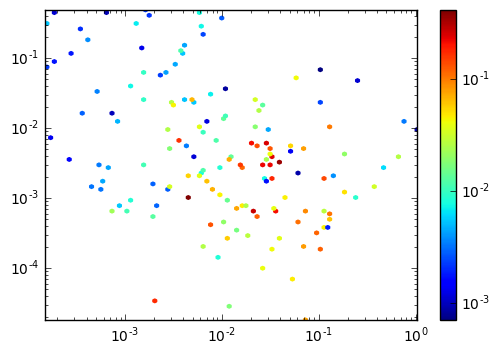

In [15]:
plt.hexbin(np.sqrt(df1.epsE11**2+df1.epsE12**2+df1.epsE13**2),\
           np.sqrt(df1.epsE21**2+df1.epsE22**2+df1.epsE23**2),\
           np.sqrt(df1.epsE31**2+df1.epsE32**2+df1.epsE33**2),xscale='log',yscale='log',norm=LogNorm())
plt.colorbar()

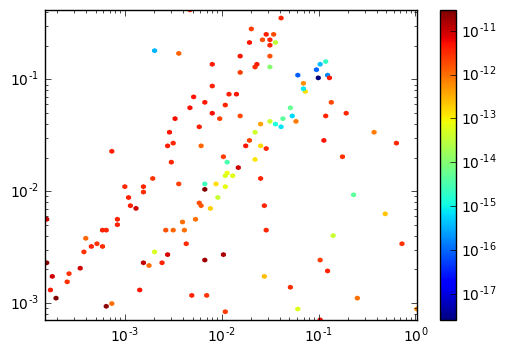

In [16]:
plt.hexbin(np.sqrt(df1.epsE11**2+df1.epsE12**2+df1.epsE13**2),\
           np.sqrt(df1.epsE31**2+df1.epsE32**2+df1.epsE33**2),\
           np.fabs(df1.Fv1),xscale='log',yscale='log',norm=LogNorm())
plt.colorbar()

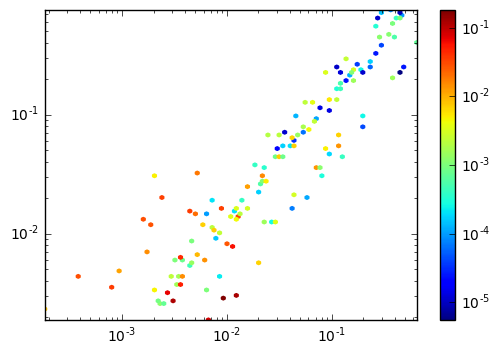

In [17]:
plt.hexbin(np.abs(df1.Yh12),np.abs(df1.Yh13),np.abs(df1.Yh23),xscale='log',yscale='log',norm=LogNorm())
plt.colorbar()

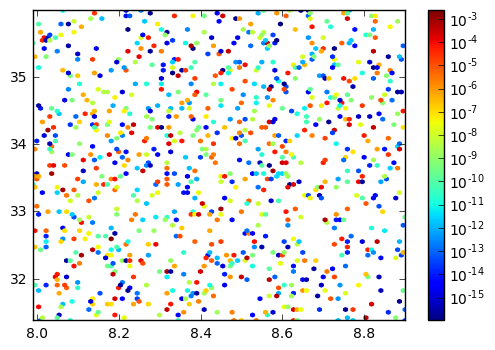

In [18]:
plt.hexbin(np.abs(df.Theta13*180.0/np.pi),np.abs(df.Theta12*180.0/np.pi),np.abs(df[3,3]),norm=LogNorm())
plt.colorbar()

,M1,M2,Q,Theta12,Theta13,Theta23,f,f12,f13,f23,...,sgnml,"(1, 1)","(1, 2)","(1, 3)","(2, 1)","(2, 2)","(2, 3)","(3, 1)","(3, 2)","(3, 3)"
283,800.0,1000.0,"[[2.5267397279, -0.00419108123332, 4.380435510...",0.568549,0.142839,0.809089,"[[0.0, 4.1137596934e-05, 0.0952954125167], [-4...",4.113760e-05,0.095295,-0.600729,...,1.0,2.526740,-0.004191,4.380436e-15,3.685954e-13,0.038671,-2.767863e-07,-0.005097,-3.723838e-14,0.002299
986,800.0,1000.0,"[[1.16033489326, 0.103193930658, -2.6579544855...",0.619922,0.153167,0.699424,"[[0.0, -4.66457736222e-06, -0.00344945887361],...",-4.664577e-06,-0.003449,-0.006597,...,-1.0,1.160335,0.103194,-2.657954e-10,-2.315273e-11,0.090170,2.491134e-05,-0.462463,5.935281e-04,0.012082
988,800.0,1000.0,"[[1.30138497736, 0.0758824286675, -2.048932535...",0.625022,0.145087,0.692647,"[[0.0, -2.06673179712e-06, 0.000540480986419],...",-2.066732e-06,0.000540,0.001493,...,1.0,1.301385,0.075882,-2.048933e-10,3.813401e-10,0.215478,8.320248e-05,-1.529122,5.744065e-04,0.013070
990,800.0,1000.0,"[[-2.12330563722, -0.0545886229696, -1.7322422...",0.560638,0.152351,0.735457,"[[0.0, 2.70596123128e-06, 0.0171689929842], [-...",2.705961e-06,0.017169,-0.109748,...,1.0,-2.123306,-0.054589,-1.732242e-15,-1.941774e-03,0.338850,-1.246932e-06,-0.033953,-5.704687e-12,0.020146
991,800.0,1000.0,"[[-1.00842692235, 0.367853774512, 1.7393236754...",0.622930,0.151671,0.733558,"[[0.0, 5.63653239122e-07, 0.000445770502512], ...",5.636532e-07,0.000446,0.001013,...,-1.0,-1.008427,0.367854,1.739324e-15,1.434980e-14,0.832606,-1.365319e-04,1.324368,-7.826751e-12,0.049127


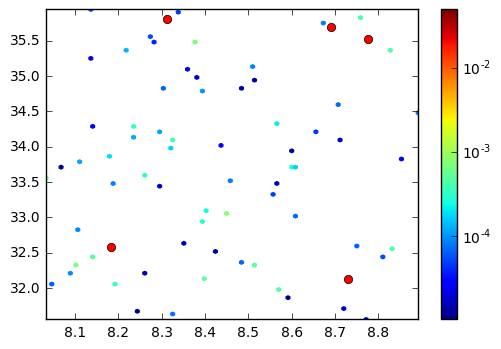

In [36]:
df2 = df[df[3,3]>1.0E-05]
df3 = df[df[3,3]>1.0E-03]
plt.hexbin(np.abs(df2.Theta13*180.0/np.pi),np.abs(df2.Theta12*180.0/np.pi),np.abs(df2[3,3]),norm=LogNorm())
plt.plot(np.abs(df3.Theta13*180.0/np.pi),np.abs(df3.Theta12*180.0/np.pi),'ro')
plt.colorbar()
df1.shape
df3

In [20]:
npoints = 30000
omin=1E-15;omax=3
o33min=1E-2;o33max=3
m1min=1E-27;m1max=1E-11
for i in range(npoints):
    O=pd.Series({'s2phi':0.014,'M1':800,'M2':1000,'m1':0,(1,2):1e-3,(1,3):1e-6,(2,1):200e-3,(2,3):0,(3,2):-1e-5,(3,3):0})
    for ij in [(1,2),(1,3),(2,1),(2,3),(3,2),(3,3)]:
        if (ij==(3,3)):
            O[ij]=rndm_sgn()*np.exp(np.random.uniform(np.log(o33min),np.log(o33max)))
        else:
            O[ij]=rndm_sgn()*np.exp(np.random.uniform(np.log(omin),np.log(omax)))

    t12=np.exp(np.random.uniform(np.log(31.38*np.pi/180.0),np.log(35.99*np.pi/180.0)))
    t13=np.exp(np.random.uniform(np.log(8.03*np.pi/180.0),np.log(8.93*np.pi/180.0)))
    t23=np.exp(np.random.uniform(np.log(38.8*np.pi/180.0),np.log(53.1*np.pi/180.0)))
    O['Theta12']=t12
    O['Theta13']=t13
    O['Theta23']=t23
    O.m1=rndm_sgn()*np.exp(np.random.uniform(np.log(m1min),np.log(m1max))) #in GeV
    kappa=Kappa(O.s2phi,O.M1,O.M2)
    O['kappa']=kappa
    sgnm2=rndm_sgn()
    sgnml=rndm_sgn()
    X=Inverse_Zee_Matrix(kappa,t12,t13,t23,O.m1,IH=False,sgnm2=sgnm2,sgnml=sgnml)
    Q,f=get_yukawas(X,q01=O[1,2],q02=O[1,3],q10=O[2,1],q12=O[2,3],q21=O[3,2],q22=O[3,3])
    if check_real(Q) and check_real(f) and np.abs(np.append(Q,f)).max()<=omax:
        O=O.append(pd.Series({(1,1):Q[0,0],(2,2):Q[1,1],(3,1):Q[2,0],'f12':f[0,1],'f13':f[0,2],'f23':f[1,2],\
                            'sgnm2':sgnm2,'sgnml':sgnml,'Q':Q,'f':f}))
        df=df.append(O,ignore_index=True)
    
df.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in double_scalars


(994, 24)

In [21]:
if df.shape[0]==1:
    print 'Test'
    m_e=0.5109989461e-3;m_mu=0.1056583745;m_tau=1.77686
    mlep=np.diag([m_e,m_mu,m_tau])

    Mnu=Kappa(s2phi,M1,M2)*( np.dot( np.dot(Q,mlep),f.transpose() )+np.dot( np.dot(f,mlep),Q.transpose()) )
    Mnu_diag,U=np.linalg.eig(Mnu)
    lo=np.argsort(np.abs(Mnu_diag))
    Mnu_diag=np.array([Mnu_diag[lo[1]],Mnu_diag[lo[2]],Mnu_diag[lo[0]]])
    U=np.matrix(U)
    U=np.asarray(np.hstack((U[:,lo[1]],U[:,lo[2]],U[:,lo[0]])))
    mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(CL=3,IH=False,mnu1in=1E-5*1E-9)  
    theta12[1]=df.Theta12
    theta13[1]=df.Theta13
    theta23[1]=df.Theta23
    m2=np.sqrt(O.m3**2-Dm3l_2[1]); m1=np.sqrt(m2**2-Dm21_2[1])
    
    np.testing.assert_array_almost_equal(np.abs(U),\
        np.abs( hp.UPMNS(theta12[1],theta13[1],theta23[1]) ) )
    
    np.testing.assert_almost_equal( np.abs(Mnu_diag)*1E11,np.abs([O.m1,m2,m3])*1E11 )

In [47]:
df2 = df[df[3,3]>1.0E-05]
df3 = df[df[3,3]>1.0E-03]

In [37]:
N = df3.f.shape[0]

df4=pd.DataFrame()

if(N > 0):
    for i in range(N):   
        Yh12 = df3.f[i][0,1]     # Yh(1,2)
        Yh13 = df3.f[i][0,2]     # Yh(1,3)
        Yh21 = df3.f[i][1,0]     # Yh(2,1)
        Yh23 = df3.f[i][1,2]     # Yh(2,3)
        Yh31 = df3.f[i][2,0]     # Yh(3,1)
        Yh32 = df3.f[i][2,1]     # Yh(3,2)

        a.LHA.blocks['YHIN'][(1,2)]='%0.8E      # Yh(1,2)'    %Yh12
        a.LHA.blocks['YHIN'][(1,3)]='%0.8E      # Yh(1,3)'    %Yh13
        a.LHA.blocks['YHIN'][(2,1)]='%0.8E      # Yh(2,1)'    %Yh21
        a.LHA.blocks['YHIN'][(2,3)]='%0.8E      # Yh(2,3)'    %Yh23
        a.LHA.blocks['YHIN'][(3,1)]='%0.8E      # Yh(3,1)'    %Yh31
        a.LHA.blocks['YHIN'][(3,2)]='%0.8E      # Yh(3,2)'    %Yh32

        epsE11 = df3.Q[i][0,0]          # epsE(1,1)
        epsE12 = df3.Q[i][0,1]          # epsE(1,2)
        epsE13 = df3.Q[i][0,2]          # epsE(1,3)
        epsE21 = df3.Q[i][1,0]          # epsE(2,1)
        epsE22 = df3.Q[i][1,1]          # epsE(2,2)
        epsE23 = df3.Q[i][1,2]          # epsE(2,3)
        epsE31 = df3.Q[i][2,0]          # epsE(3,1)
        epsE32 = df3.Q[i][2,1]          # epsE(3,2)
        epsE33 = df3.Q[i][2,2]          # epsE(3,3)

        a.LHA.blocks['EPSEIN'][(1,1)]='%0.8E      # epsE(1,1)'    %epsE11
        a.LHA.blocks['EPSEIN'][(1,2)]='%0.8E      # epsE(1,2)'    %epsE12
        a.LHA.blocks['EPSEIN'][(1,3)]='%0.8E      # epsE(1,3)'    %epsE13
        a.LHA.blocks['EPSEIN'][(2,1)]='%0.8E      # epsE(2,1)'    %epsE21
        a.LHA.blocks['EPSEIN'][(2,2)]='%0.8E      # epsE(2,2)'    %epsE22
        a.LHA.blocks['EPSEIN'][(2,3)]='%0.8E      # epsE(2,3)'    %epsE23
        a.LHA.blocks['EPSEIN'][(3,1)]='%0.8E      # epsE(3,1)'    %epsE31
        a.LHA.blocks['EPSEIN'][(3,2)]='%0.8E      # epsE(3,2)'    %epsE32
        a.LHA.blocks['EPSEIN'][(3,3)]='%0.8E      # epsE(3,3)'    %epsE33
    
        tanbetha = 1.0

        Yd33 = 0.0240086062
        Yu33 = 0.996529469
        epsD33 = Yd33*tanbetha
        epsU33 = Yu33*tanbetha 
    
        a.LHA.blocks['EPSDIN'][(3,3)]='%0.8E      # epsD(3,3)'    %epsD33
        a.LHA.blocks['EPSUIN'][(3,3)]='%0.8E      # epsU(3,3)'    %epsU33

        moc=a.runSPheno() 

        Brmuegamma = a.LHA_out.blocks['FLAVORKITLFV'][701]     #BR(mu->e gamma)
        Brtauegamma = a.LHA_out.blocks['FLAVORKITLFV'][702]    #BR(tau->e gamma)
        Brtaumugamma = a.LHA_out.blocks['FLAVORKITLFV'][703]   #BR(tau->mu gamma)     
        Brmu3e = a.LHA_out.blocks['FLAVORKITLFV'][901]         #BR(mu->3e)
        Brtau3mu = a.LHA_out.blocks['FLAVORKITLFV'][903]       #BR(tau->3mu)    
        Brtauemumu = a.LHA_out.blocks['FLAVORKITLFV'][904]     #BR(tau- -> e- mu+ mu-) 
        Brtaumuee = a.LHA_out.blocks['FLAVORKITLFV'][905]      #BR(tau- -> mu- e+ e-)
        Brtau3e = a.LHA_out.blocks['FLAVORKITLFV'][902]        #BR(tau->3e)
        CrmueTi = a.LHA_out.blocks['FLAVORKITLFV'][801]        #CR(mu-e, Ti) 
        CrmueAu = a.LHA_out.blocks['FLAVORKITLFV'][804]        #CR(mu-e, Au)    
    
        FLFV = np.array([Brmuegamma, Brtauegamma, Brtaumugamma, Brmu3e, Brtau3mu, Brtauemumu, Brtaumuee, Brtau3e, CrmueTi, CrmueAu])
        #print FLFV
        if np.all(FLFV < LFV):    
            a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['MASS']))
            a.branchings(a.LHA_out.decays,min_pdg=25)
            a.Series=a.Series.append(a.Br_names)
            a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['FLAVORKITLFV']))
            a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSE']))
            a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSD']))
            a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSU']))
            a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['YH']))
    
            df4=df4.append(a.Series,ignore_index=True)
            df4=df4.fillna(0)
        
df4.shape

KeyError: 0

In [ ]:
plt.hexbin(np.abs(df4.Theta13*180.0/np.pi),np.abs(df4.Theta12*180.0/np.pi),np.abs(df4[3,3]),norm=LogNorm())
plt.colorbar()

In [ ]:
plt.hexbin(np.abs(df4.Theta13*180.0/np.pi),np.abs(df4[3,3]),np.abs(df4.Theta12*180.0/np.pi),yscale='log',norm=LogNorm())
plt.colorbar()

In [ ]:
plt.hexbin(np.abs(df4.Theta12*180.0/np.pi),np.abs(df4[3,3]),np.abs(df4.Theta13*180.0/np.pi),yscale='log',norm=LogNorm())
plt.colorbar()

# Inverse Hierarchy

In [ ]:
# def check_real(x):
    ab=np.unique(np.isnan(x)) #np.unique( np.equal( np.imag(x),np.zeros(x.shape) ) )
    chr=False
    #if ab.shape[0]==1 and ab[0]:
    if ab.shape[0]==1 and not ab[0]:
        chr=True
    return chr

def rndm_sgn():
    return np.random.choice([1,-1])

dfi=pd.DataFrame()
npoints=100000
omin=1E-16;omax=3
m3min=1E-27;m3max=1E-11
for i in range(npoints):
    O=pd.Series({'s2phi':0.014,'M1':800,'M2':1000,'m3':0,(1,2):1e-3,(1,3):1e-6,(2,1):200e-3,(2,3):0,(3,2):-1e-5,(3,3):0})
    for ij in [(1,2),(1,3),(2,1),(2,3),(3,2),(3,3)]:
        O[ij]=rndm_sgn()*np.exp(np.random.uniform(np.log(omin),np.log(omax)))
                
    t12=np.exp(np.random.uniform(np.log(31.38*np.pi/180.0),np.log(35.99*np.pi/180.0)))
    t13=np.exp(np.random.uniform(np.log(7.99*np.pi/180.0),np.log(8.90*np.pi/180.0)))
    t23=np.exp(np.random.uniform(np.log(38.4*np.pi/180.0),np.log(52.8*np.pi/180.0)))
    O['Theta12']=t12
    O['Theta13']=t13
    O['Theta23']=t23
    O.m3=rndm_sgn()*np.exp(np.random.uniform(np.log(m1min),np.log(m1max))) #in GeV
    kappa=Kappa(O.s2phi,O.M1,O.M2)
    O['kappa']=kappa
    sgnm2=rndm_sgn()
    sgnml=rndm_sgn()
    X=Inverse_Zee_Matrix(kappa,t12,t13,t23,O.m3,IH=True,sgnm2=sgnm2,sgnml=sgnml)
    Q,f=get_yukawas(X,q01=O[1,2],q02=O[1,3],q10=O[2,1],q12=O[2,3],q21=O[3,2],q22=O[3,3])
    if check_real(Q) and check_real(f) and np.abs(np.append(Q,f)).max()<=omax:
        O=O.append(pd.Series({(1,1):Q[0,0],(2,2):Q[1,1],(3,1):Q[2,0],'f12':f[0,1],'f13':f[0,2],'f23':f[1,2],\
                            'sgnm2':sgnm2,'sgnml':sgnml,'Q':Q,'f':f}))
        dfi=dfi.append(O,ignore_index=True)
    
dfi.shape

In [ ]:
if dfi.shape[0]==1:
    print 'Test'
    m_e=0.5109989461e-3;m_mu=0.1056583745;m_tau=1.77686
    mlep=np.diag([m_e,m_mu,m_tau])

    Mnu=Kappa(s2phi,M1,M2)*( np.dot( np.dot(Q,mlep),f.transpose() )+np.dot( np.dot(f,mlep),Q.transpose()) )
    Mnu_diag,U=np.linalg.eig(Mnu)
    lo=np.argsort(np.abs(Mnu_diag))
    Mnu_diag=np.array([Mnu_diag[lo[1]],Mnu_diag[lo[2]],Mnu_diag[lo[0]]])
    U=np.matrix(U)
    U=np.asarray(np.hstack((U[:,lo[1]],U[:,lo[2]],U[:,lo[0]])))
    mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(CL=3,IH=True,mnu1in=1E-5*1E-9)  
    m2=np.sqrt(O.m3**2-Dm3l_2[1]); m1=np.sqrt(m2**2-Dm21_2[1])
    theta12[1]=df.Theta12
    theta13[1]=df.Theta13
    theta23[1]=df.Theta23
    
    np.testing.assert_array_almost_equal(np.abs(U),\
        np.abs( hp.UPMNS(theta12[1],theta13[1],theta23[1]) ) )
    
    np.testing.assert_almost_equal( np.abs(Mnu_diag)*1E11,np.abs([O.m1,m2,m3])*1E11 )

In [ ]:
N = dfi.f.shape[0]

dfi1=pd.DataFrame()

for i in range(N):   
    Yh12 = dfi.f[i][0,1]     # Yh(1,2)
    Yh13 = dfi.f[i][0,2]     # Yh(1,3)
    Yh21 = dfi.f[i][1,0]     # Yh(2,1)
    Yh23 = dfi.f[i][1,2]     # Yh(2,3)
    Yh31 = dfi.f[i][2,0]     # Yh(3,1)
    Yh32 = dfi.f[i][2,1]     # Yh(3,2)

    a.LHA.blocks['YHIN'][(1,2)]='%0.8E      # Yh(1,2)'    %Yh12
    a.LHA.blocks['YHIN'][(1,3)]='%0.8E      # Yh(1,3)'    %Yh13
    a.LHA.blocks['YHIN'][(2,1)]='%0.8E      # Yh(2,1)'    %Yh21
    a.LHA.blocks['YHIN'][(2,3)]='%0.8E      # Yh(2,3)'    %Yh23
    a.LHA.blocks['YHIN'][(3,1)]='%0.8E      # Yh(3,1)'    %Yh31
    a.LHA.blocks['YHIN'][(3,2)]='%0.8E      # Yh(3,2)'    %Yh32

    epsE11 = dfi.Q[i][0,0]          # epsE(1,1)
    epsE12 = dfi.Q[i][0,1]          # epsE(1,2)
    epsE13 = dfi.Q[i][0,2]          # epsE(1,3)
    epsE21 = dfi.Q[i][1,0]          # epsE(2,1)
    epsE22 = dfi.Q[i][1,1]          # epsE(2,2)
    epsE23 = dfi.Q[i][1,2]          # epsE(2,3)
    epsE31 = dfi.Q[i][2,0]          # epsE(3,1)
    epsE32 = dfi.Q[i][2,1]          # epsE(3,2)
    epsE33 = dfi.Q[i][2,2]          # epsE(3,3)

    a.LHA.blocks['EPSEIN'][(1,1)]='%0.8E      # epsE(1,1)'    %epsE11
    a.LHA.blocks['EPSEIN'][(1,2)]='%0.8E      # epsE(1,2)'    %epsE12
    a.LHA.blocks['EPSEIN'][(1,3)]='%0.8E      # epsE(1,3)'    %epsE13
    a.LHA.blocks['EPSEIN'][(2,1)]='%0.8E      # epsE(2,1)'    %epsE21
    a.LHA.blocks['EPSEIN'][(2,2)]='%0.8E      # epsE(2,2)'    %epsE22
    a.LHA.blocks['EPSEIN'][(2,3)]='%0.8E      # epsE(2,3)'    %epsE23
    a.LHA.blocks['EPSEIN'][(3,1)]='%0.8E      # epsE(3,1)'    %epsE31
    a.LHA.blocks['EPSEIN'][(3,2)]='%0.8E      # epsE(3,2)'    %epsE32
    a.LHA.blocks['EPSEIN'][(3,3)]='%0.8E      # epsE(3,3)'    %epsE33
    
    tanbetha = 1.0

    Yd33 = 0.0240086062
    Yu33 = 0.996529469
    epsD33 = Yd33*tanbetha
    epsU33 = Yu33*tanbetha 
    
    a.LHA.blocks['EPSDIN'][(3,3)]='%0.8E      # epsD(3,3)'    %epsD33
    a.LHA.blocks['EPSUIN'][(3,3)]='%0.8E      # epsU(3,3)'    %epsU33

    moc=a.runSPheno() 

    Brmuegamma = a.LHA_out.blocks['FLAVORKITLFV'][701]     #BR(mu->e gamma)
    Brtauegamma = a.LHA_out.blocks['FLAVORKITLFV'][702]    #BR(tau->e gamma)
    Brtaumugamma = a.LHA_out.blocks['FLAVORKITLFV'][703]   #BR(tau->mu gamma)     
    Brmu3e = a.LHA_out.blocks['FLAVORKITLFV'][901]         #BR(mu->3e)
    Brtau3mu = a.LHA_out.blocks['FLAVORKITLFV'][903]       #BR(tau->3mu)    
    Brtauemumu = a.LHA_out.blocks['FLAVORKITLFV'][904]     #BR(tau- -> e- mu+ mu-) 
    Brtaumuee = a.LHA_out.blocks['FLAVORKITLFV'][905]      #BR(tau- -> mu- e+ e-)
    Brtau3e = a.LHA_out.blocks['FLAVORKITLFV'][902]        #BR(tau->3e)
    CrmueTi = a.LHA_out.blocks['FLAVORKITLFV'][801]        #CR(mu-e, Ti) 
    CrmueAu = a.LHA_out.blocks['FLAVORKITLFV'][804]        #CR(mu-e, Au)    
    
    FLFV = np.array([Brmuegamma, Brtauegamma, Brtaumugamma, Brmu3e, Brtau3mu, Brtauemumu, Brtaumuee, Brtau3e, CrmueTi, CrmueAu])
    #print FLFV
    if np.all(FLFV < LFV):    
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['MASS']))
        a.branchings(a.LHA_out.decays,min_pdg=25)
        a.Series=a.Series.append(a.Br_names)
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['FLAVORKITLFV']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSE']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSD']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSU']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['YH']))
    
        dfi1=dfi1.append(a.Series,ignore_index=True)
        dfi1=dfi1.fillna(0)
        
dfi1.shape

In [ ]:
plt.hexbin(np.sqrt(dfi1.epsE11**2+dfi1.epsE12**2+dfi1.epsE13**2),\
           np.sqrt(dfi1.epsE21**2+dfi1.epsE22**2+dfi1.epsE23**2),\
           np.sqrt(dfi1.epsE31**2+dfi1.epsE32**2+dfi1.epsE33**2),xscale='log',yscale='log',norm=LogNorm())
plt.colorbar()

In [ ]:
plt.hexbin(np.sqrt(dfi1.epsE11**2+dfi1.epsE12**2+dfi1.epsE13**2),\
           np.sqrt(dfi1.epsE31**2+dfi1.epsE32**2+dfi1.epsE33**2),\
           np.fabs(dfi1.Fv1),xscale='log',yscale='log',norm=LogNorm())
plt.colorbar()

In [ ]:
plt.hexbin(np.abs(dfi1.Yh12),np.abs(dfi1.Yh13),np.abs(dfi1.Yh23),xscale='log',yscale='log',norm=LogNorm())
plt.colorbar()

In [ ]:
plt.hexbin(np.abs(dfi1.Theta13*180.0/np.pi),np.abs(dfi1.Theta12*180.0/np.pi),np.abs(dfi1[3,3]),norm=LogNorm())
plt.colorbar()

In [ ]:
dfi2 = dfi[dfi[3,3]>1.0E-05]
dfi3 = dfi[dfi[3,3]>1.0E-03]
plt.hexbin(np.abs(dfi2.Theta13*180.0/np.pi),np.abs(dfi2.Theta12*180.0/np.pi),np.abs(dfi2[3,3]),norm=LogNorm())
plt.plot(np.abs(dfi3.Theta13*180.0/np.pi),np.abs(dfi3.Theta12*180.0/np.pi),'ro')
plt.colorbar()
dfi2.shape

In [ ]:
npoints = 300000
omin=1E-15;omax=3
o33min=1E-2;o33max=3
m3min=1E-27;m3max=1E-11
for i in range(npoints):
    O=pd.Series({'s2phi':0.014,'M1':800,'M2':1000,'m1':0,(1,2):1e-3,(1,3):1e-6,(2,1):200e-3,(2,3):0,(3,2):-1e-5,(3,3):0})
    for ij in [(1,2),(1,3),(2,1),(2,3),(3,2),(3,3)]:
        if (ij==(3,3)):
            O[ij]=rndm_sgn()*np.exp(np.random.uniform(np.log(o33min),np.log(o33max)))
        else:
            O[ij]=rndm_sgn()*np.exp(np.random.uniform(np.log(omin),np.log(omax)))

    t12=np.exp(np.random.uniform(np.log(31.38*np.pi/180.0),np.log(35.99*np.pi/180.0)))
    t13=np.exp(np.random.uniform(np.log(8.03*np.pi/180.0),np.log(8.93*np.pi/180.0)))
    t23=np.exp(np.random.uniform(np.log(38.8*np.pi/180.0),np.log(53.1*np.pi/180.0)))
    O['Theta12']=t12
    O['Theta13']=t13
    O['Theta23']=t23
    O.m3=rndm_sgn()*np.exp(np.random.uniform(np.log(m3min),np.log(m3max))) #in GeV
    kappa=Kappa(O.s2phi,O.M1,O.M2)
    O['kappa']=kappa
    sgnm2=rndm_sgn()
    sgnml=rndm_sgn()
    X=Inverse_Zee_Matrix(kappa,t12,t13,t23,O.m1,IH=True,sgnm2=sgnm2,sgnml=sgnml)
    Q,f=get_yukawas(X,q01=O[1,2],q02=O[1,3],q10=O[2,1],q12=O[2,3],q21=O[3,2],q22=O[3,3])
    if check_real(Q) and check_real(f) and np.abs(np.append(Q,f)).max()<=omax:
        O=O.append(pd.Series({(1,1):Q[0,0],(2,2):Q[1,1],(3,1):Q[2,0],'f12':f[0,1],'f13':f[0,2],'f23':f[1,2],\
                            'sgnm2':sgnm2,'sgnml':sgnml,'Q':Q,'f':f}))
        dfi=dfi.append(O,ignore_index=True)
    
dfi.shape

In [ ]:
if dfi.shape[0]==1:
    print 'Test'
    m_e=0.5109989461e-3;m_mu=0.1056583745;m_tau=1.77686
    mlep=np.diag([m_e,m_mu,m_tau])

    Mnu=Kappa(s2phi,M1,M2)*( np.dot( np.dot(Q,mlep),f.transpose() )+np.dot( np.dot(f,mlep),Q.transpose()) )
    Mnu_diag,U=np.linalg.eig(Mnu)
    lo=np.argsort(np.abs(Mnu_diag))
    Mnu_diag=np.array([Mnu_diag[lo[1]],Mnu_diag[lo[2]],Mnu_diag[lo[0]]])
    U=np.matrix(U)
    U=np.asarray(np.hstack((U[:,lo[1]],U[:,lo[2]],U[:,lo[0]])))
    mltmp,Dm21_2,Dm3l_2,theta12,theta23,theta13,delta=hp.neutrino_data(CL=3,IH=False,mnu1in=1E-5*1E-9)  
    theta12[1]=df.Theta12
    theta13[1]=df.Theta13
    theta23[1]=df.Theta23
    m2=np.sqrt(O.m3**2-Dm3l_2[1]); m1=np.sqrt(m2**2-Dm21_2[1])
    
    np.testing.assert_array_almost_equal(np.abs(U),\
        np.abs( hp.UPMNS(theta12[1],theta13[1],theta23[1]) ) )
    
    np.testing.assert_almost_equal( np.abs(Mnu_diag)*1E11,np.abs([O.m1,m2,m3])*1E11 )

In [ ]:
dfi2 = dfi[dfi[3,3]>1.0E-05]
dfi3 = dfi[dfi[3,3]>1.0E-03]

In [ ]:
N = dfi3.f.shape[0]

dfi4=pd.DataFrame()

for i in range(N):   
    Yh12 = dfi3.f[i][0,1]     # Yh(1,2)
    Yh13 = dfi3.f[i][0,2]     # Yh(1,3)
    Yh21 = dfi3.f[i][1,0]     # Yh(2,1)
    Yh23 = dfi3.f[i][1,2]     # Yh(2,3)
    Yh31 = dfi3.f[i][2,0]     # Yh(3,1)
    Yh32 = dfi3.f[i][2,1]     # Yh(3,2)

    a.LHA.blocks['YHIN'][(1,2)]='%0.8E      # Yh(1,2)'    %Yh12
    a.LHA.blocks['YHIN'][(1,3)]='%0.8E      # Yh(1,3)'    %Yh13
    a.LHA.blocks['YHIN'][(2,1)]='%0.8E      # Yh(2,1)'    %Yh21
    a.LHA.blocks['YHIN'][(2,3)]='%0.8E      # Yh(2,3)'    %Yh23
    a.LHA.blocks['YHIN'][(3,1)]='%0.8E      # Yh(3,1)'    %Yh31
    a.LHA.blocks['YHIN'][(3,2)]='%0.8E      # Yh(3,2)'    %Yh32

    epsE11 = dfi3.Q[i][0,0]          # epsE(1,1)
    epsE12 = dfi3.Q[i][0,1]          # epsE(1,2)
    epsE13 = dfi3.Q[i][0,2]          # epsE(1,3)
    epsE21 = dfi3.Q[i][1,0]          # epsE(2,1)
    epsE22 = dfi3.Q[i][1,1]          # epsE(2,2)
    epsE23 = dfi3.Q[i][1,2]          # epsE(2,3)
    epsE31 = dfi3.Q[i][2,0]          # epsE(3,1)
    epsE32 = dfi3.Q[i][2,1]          # epsE(3,2)
    epsE33 = dfi3.Q[i][2,2]          # epsE(3,3)

    a.LHA.blocks['EPSEIN'][(1,1)]='%0.8E      # epsE(1,1)'    %epsE11
    a.LHA.blocks['EPSEIN'][(1,2)]='%0.8E      # epsE(1,2)'    %epsE12
    a.LHA.blocks['EPSEIN'][(1,3)]='%0.8E      # epsE(1,3)'    %epsE13
    a.LHA.blocks['EPSEIN'][(2,1)]='%0.8E      # epsE(2,1)'    %epsE21
    a.LHA.blocks['EPSEIN'][(2,2)]='%0.8E      # epsE(2,2)'    %epsE22
    a.LHA.blocks['EPSEIN'][(2,3)]='%0.8E      # epsE(2,3)'    %epsE23
    a.LHA.blocks['EPSEIN'][(3,1)]='%0.8E      # epsE(3,1)'    %epsE31
    a.LHA.blocks['EPSEIN'][(3,2)]='%0.8E      # epsE(3,2)'    %epsE32
    a.LHA.blocks['EPSEIN'][(3,3)]='%0.8E      # epsE(3,3)'    %epsE33
    
    tanbetha = 1.0

    Yd33 = 0.0240086062
    Yu33 = 0.996529469
    epsD33 = Yd33*tanbetha
    epsU33 = Yu33*tanbetha 
    
    a.LHA.blocks['EPSDIN'][(3,3)]='%0.8E      # epsD(3,3)'    %epsD33
    a.LHA.blocks['EPSUIN'][(3,3)]='%0.8E      # epsU(3,3)'    %epsU33

    moc=a.runSPheno() 

    Brmuegamma = a.LHA_out.blocks['FLAVORKITLFV'][701]     #BR(mu->e gamma)
    Brtauegamma = a.LHA_out.blocks['FLAVORKITLFV'][702]    #BR(tau->e gamma)
    Brtaumugamma = a.LHA_out.blocks['FLAVORKITLFV'][703]   #BR(tau->mu gamma)     
    Brmu3e = a.LHA_out.blocks['FLAVORKITLFV'][901]         #BR(mu->3e)
    Brtau3mu = a.LHA_out.blocks['FLAVORKITLFV'][903]       #BR(tau->3mu)    
    Brtauemumu = a.LHA_out.blocks['FLAVORKITLFV'][904]     #BR(tau- -> e- mu+ mu-) 
    Brtaumuee = a.LHA_out.blocks['FLAVORKITLFV'][905]      #BR(tau- -> mu- e+ e-)
    Brtau3e = a.LHA_out.blocks['FLAVORKITLFV'][902]        #BR(tau->3e)
    CrmueTi = a.LHA_out.blocks['FLAVORKITLFV'][801]        #CR(mu-e, Ti) 
    CrmueAu = a.LHA_out.blocks['FLAVORKITLFV'][804]        #CR(mu-e, Au)    
    
    FLFV = np.array([Brmuegamma, Brtauegamma, Brtaumugamma, Brmu3e, Brtau3mu, Brtauemumu, Brtaumuee, Brtau3e, CrmueTi, CrmueAu])
    #print FLFV
    if np.all(FLFV < LFV):    
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['MASS']))
        a.branchings(a.LHA_out.decays,min_pdg=25)
        a.Series=a.Series.append(a.Br_names)
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['FLAVORKITLFV']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSE']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSD']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['EPSU']))
        a.Series=a.Series.append(hp.block_to_series(a.LHA_out_with_comments.blocks['YH']))
    
        dfi4=dfi4.append(a.Series,ignore_index=True)
        dfi4=dfi4.fillna(0)
        
dfi4.shape

In [ ]:
plt.hexbin(np.abs(dfi4.Theta13*180.0/np.pi),np.abs(dfi4.Theta12*180.0/np.pi),np.abs(dfi4[3,3]),norm=LogNorm())
plt.colorbar()
df1.shape

In [ ]:
plt.hexbin(np.abs(dfi4.Theta13*180.0/np.pi),np.abs(dfi4[3,3]),np.abs(dfi4.Theta12*180.0/np.pi),yscale='log',norm=LogNorm())
plt.colorbar()

In [ ]:
plt.hexbin(np.abs(dfi4.Theta12*180.0/np.pi),np.abs(dfi4[3,3]),np.abs(dfi4.Theta13*180.0/np.pi),yscale='log',norm=LogNorm())
plt.colorbar()

[![Home](http://www.incredimail.com/images/nav%20bar/home-icon.png)](./) 
[Jupyter home](./draft.pdf)